## Import modules and libraries

In [112]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
from sklearn.model_selection import GridSearchCV, StratifiedKFold

#mpl.rcParams['figure.dpi'] = 100
random_state = 42
sns.reset_defaults()

## Read data

In [113]:
# Read data
df = pd.read_csv('earthquake_data_tsunami.csv')
print(f"Data shape:\n {df.shape}\n")
print(df.info()) # check missing (null) values
print(df.describe())

Data shape:
 (782, 13)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 782 entries, 0 to 781
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   magnitude  782 non-null    float64
 1   cdi        782 non-null    int64  
 2   mmi        782 non-null    int64  
 3   sig        782 non-null    int64  
 4   nst        782 non-null    int64  
 5   dmin       782 non-null    float64
 6   gap        782 non-null    float64
 7   depth      782 non-null    float64
 8   latitude   782 non-null    float64
 9   longitude  782 non-null    float64
 10  Year       782 non-null    int64  
 11  Month      782 non-null    int64  
 12  tsunami    782 non-null    int64  
dtypes: float64(6), int64(7)
memory usage: 79.6 KB
None
        magnitude         cdi         mmi          sig         nst  \
count  782.000000  782.000000  782.000000   782.000000  782.000000   
mean     6.941125    4.333760    5.964194   870.108696  230.250639   
std  

   tsunami  count  percentage
0        0    478    61.12532
1        1    304    38.87468


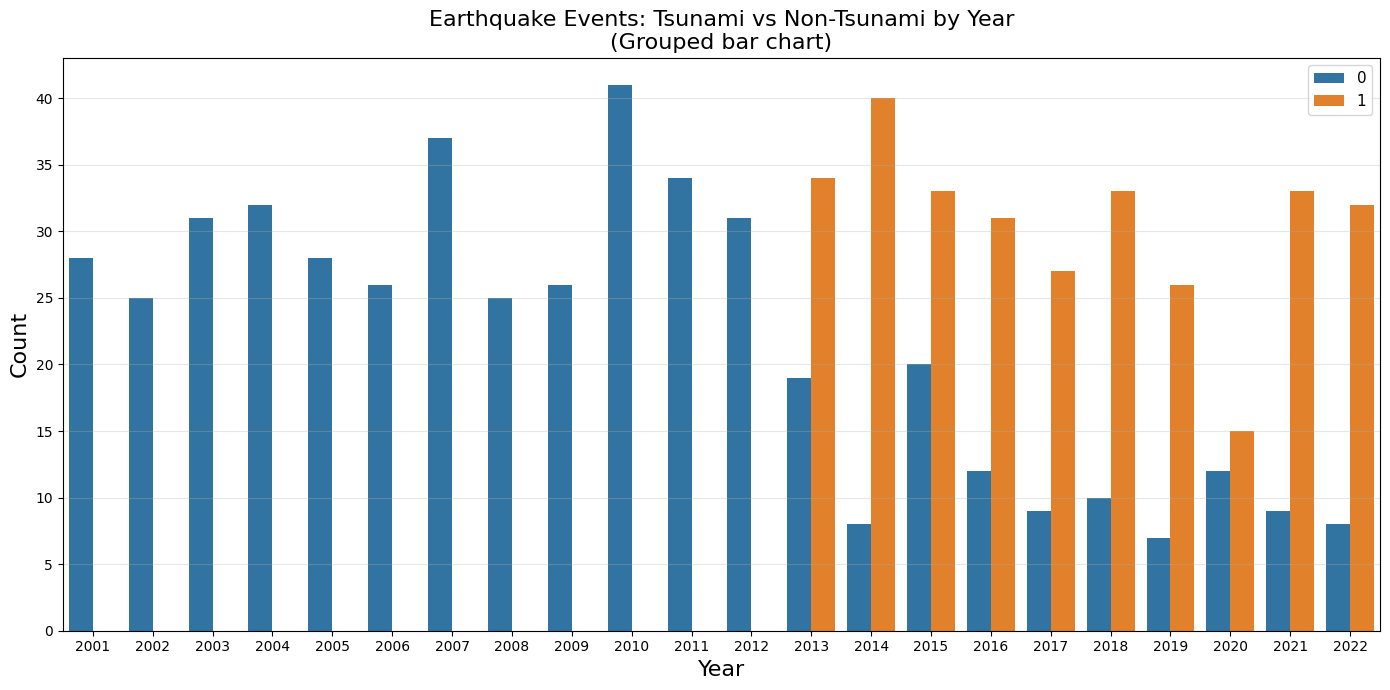

In [114]:
# Total tsunami count
tsunami_counts = df['tsunami'].value_counts().rename('count').reset_index()
tsunami_counts['percentage'] = tsunami_counts['count'] / tsunami_counts['count'].sum() * 100
print(tsunami_counts)

# Plot tsunami counts by year
tsunami_counts_by_year = df.groupby('Year')['tsunami'].value_counts().rename('count').reset_index()
fig, ax = plt.subplots(figsize=(14, 7))
sns.barplot(data=tsunami_counts_by_year, x='Year', y='count', hue='tsunami', ax=ax)
ax.set_xlabel('Year', fontsize=16)
ax.set_ylabel('Count', fontsize=16)
ax.set_title('Earthquake Events: Tsunami vs Non-Tsunami by Year\n(Grouped bar chart)', fontsize=16)
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

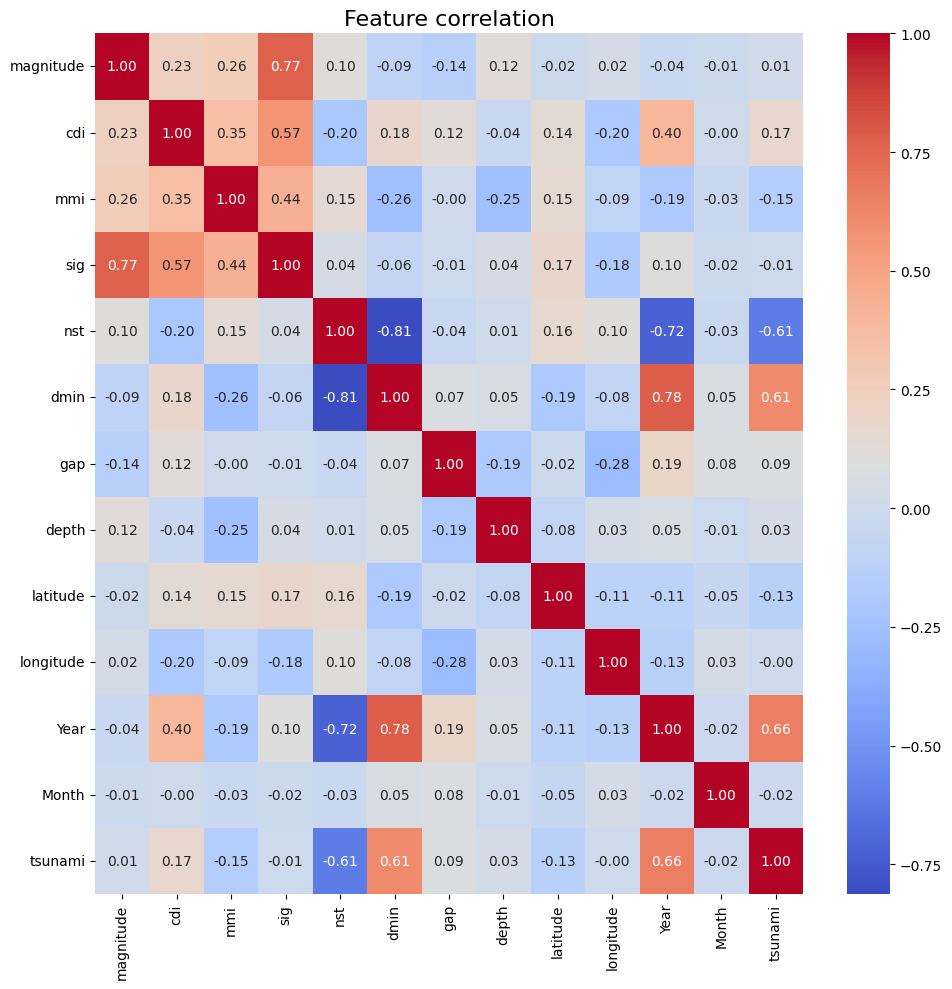

In [115]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(df.corr(method='spearman'), annot=True, fmt='.2f', ax=ax, cmap='coolwarm')
ax.set_title('Feature correlation', fontsize=16)
plt.tight_layout()
plt.show()

## Data Preprocessing

In [116]:
# Stratified train/test/valid split
X = df.drop(['tsunami', 'Year', 'Month'], axis=1)
y = df['tsunami']

# 70/15/15 train/valid/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y,
)

print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)
print()
print("Tsunami ratio")
print(f"Train set: {y_train.value_counts(normalize=True)[1]}")
print(f"Test set:  {y_test.value_counts(normalize=True)[1]}")

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print(f"Mean of X_train_scaled:  {X_train_scaled.mean():.6f}")
print(f"Standard deviation of X_train_scaled:  {X_train_scaled.std():.6f}")


X_train: (625, 10)
y_train: (625,)
X_test: (157, 10)
y_test: (157,)

Tsunami ratio
Train set: 0.3888
Test set:  0.3885350318471338
Mean of X_train_scaled:  -0.000000
Standard deviation of X_train_scaled:  1.000000


# Model Implementation

In [117]:
# Function for obtaining evaluation metrics for specified dataset
def get_eval_metrics(model, X, y_true):
    # Predictions
    y_pred = model.predict(X)
    if hasattr(model, "decision_function"):
        y_scores = model.decision_function(X)
    elif hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X)[:, 1] # Probability of Class 1
    else:
        raise AttributeError("Model does not support probability or decision function.")

    # Accuracy metrics
    metrics = {}
    metrics['Accuracy'] = accuracy_score(y_true, y_pred)
    metrics['Precision'] = precision_score(y_true, y_pred)
    metrics['Recall'] = recall_score(y_true, y_pred)
    metrics['F1 score'] = f1_score(y_true, y_pred)
    metrics['ROC-AUC'] = roc_auc_score(y_true, y_scores)

    return metrics

## Logistic Regression

A baseline model is first tested without any regularization. The model has an accuracy of 0.8223 and recall of 0.8696 on the test set.

Baseline model
Train set metrics
Accuracy: 0.816000
Precision: 0.707792
Recall: 0.897119
F1 score: 0.791289
ROC-AUC: 0.877383
Test set metrics
Accuracy: 0.815287
Precision: 0.710526
Recall: 0.885246
F1 score: 0.788321
ROC-AUC: 0.879952


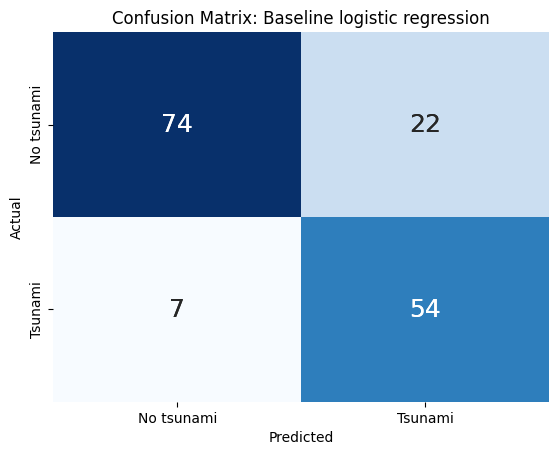

In [127]:
# class_weight = 'balanced': address class imbalance problem
# C inverse of regularization strength, smaller values has stronger regularization
# Baseline model

model = LogisticRegression(penalty=None, random_state=random_state,
                           max_iter=1000, class_weight='balanced')
model.fit(X_train_scaled, y_train)

train_metrics = get_eval_metrics(model, X_train_scaled, y_train)
test_metrics = get_eval_metrics(model, X_test_scaled, y_test)

# print metrics
print('Baseline model')
print('='*80)
print('Train set metrics')
for metric, value in train_metrics.items():
    print(f"{metric}: {value:.6f}")
print('='*80)
print('Test set metrics')
for metric, value in test_metrics.items():
    print(f"{metric}: {value:.6f}")

# print confusion matrix
y_pred = model.predict(X_test_scaled)
confusion = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(confusion, annot=True, annot_kws={"fontsize": 18}, fmt="d", cmap="Blues", cbar=False)
ax.set_title(f"Confusion Matrix: Baseline logistic regression")
ax.set_xticklabels(['No tsunami', 'Tsunami'])
ax.set_yticklabels(['No tsunami', 'Tsunami'])
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
plt.show()

Grid search with 5-fold stratified cross validation: penalty type (L1, L2), C (regularization strength), F1 score as the evaluation metric.

The best parameters found were penalty=L1 with C=0.01.



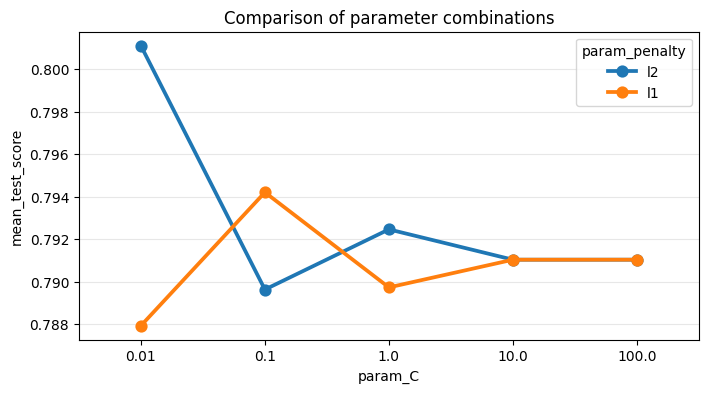

Best Parameters: {'C': 0.01, 'penalty': 'l2'}
Best Score: 0.8011131586379076


In [119]:
# Search for best parameter combinations
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
}

# Apply GridsearchCV with 5-fold cross validation
cv_split_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
gs = GridSearchCV(
    estimator=LogisticRegression(random_state=random_state, solver='liblinear',
                                 max_iter=1000, class_weight='balanced'),
    param_grid=param_grid,
    cv=cv_split_strategy,
    scoring='f1',
)
gs.fit(X_train_scaled, y_train)

# Show results comparison
results = pd.DataFrame(gs.cv_results_).sort_values(by=["rank_test_score"])
results = results[
    ["param_penalty", "param_C", "mean_test_score", "std_test_score", "rank_test_score"]
]

plt.figure(figsize=(8,4))
ax = sns.pointplot(results, x="param_C", y="mean_test_score", hue="param_penalty")
ax.set_title("Comparison of parameter combinations")
ax.grid(axis="y", alpha=0.3)
plt.show()

# Save the model with highest score
print("Best Parameters:", gs.best_params_)
print("Best Score:", gs.best_score_)
lr_model = gs.best_estimator_

## SVM
GridSearchCV: gamma, C, F1 score as the evaluation metric.

Result: lower gamma values lead to better results, changing C value has limited improvement

Best parameters: C=0.1 with gamma=0.01

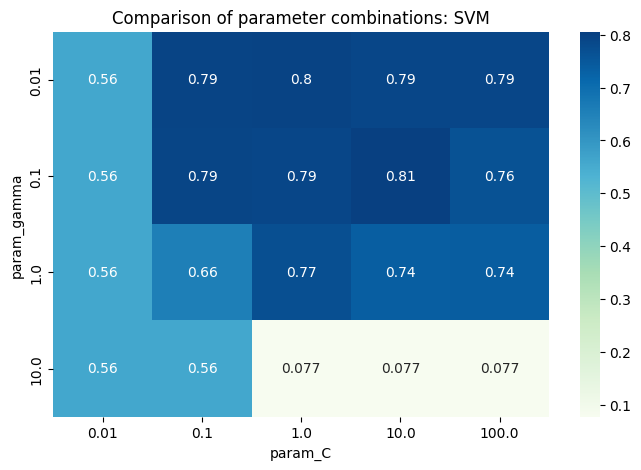

Best Parameters: {'C': 10, 'gamma': 0.1}
Best Score: 0.8057808857808857


In [120]:
# Search for best parameter combinations
param_grid = {
    'gamma': [0.01, 0.1, 1, 10],
    'C': [0.01, 0.1, 1, 10, 100],
}

# Apply GridsearchCV with 5-fold cross validation
cv_split_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
gs = GridSearchCV(
    estimator=SVC(random_state=random_state, class_weight='balanced', kernel='rbf'),
    param_grid=param_grid,
    cv=cv_split_strategy,
    scoring='f1',
)
gs.fit(X_train_scaled, y_train)

# Show results comparison
results = pd.DataFrame(gs.cv_results_).sort_values(by=["rank_test_score"])
results = results[
    ["param_gamma", "param_C", "mean_test_score", "std_test_score", "rank_test_score"]
]

plt.figure(figsize=(8,5))
results_table = results.pivot_table(index="param_gamma", columns="param_C", values="mean_test_score")
ax = sns.heatmap(results_table, annot=True, cmap="GnBu")
ax.set_title("Comparison of parameter combinations: SVM")
plt.show()

# Save the model with highest score
print("Best Parameters:", gs.best_params_)
print("Best Score:", gs.best_score_)
svm_model = gs.best_estimator_

## Random Forest

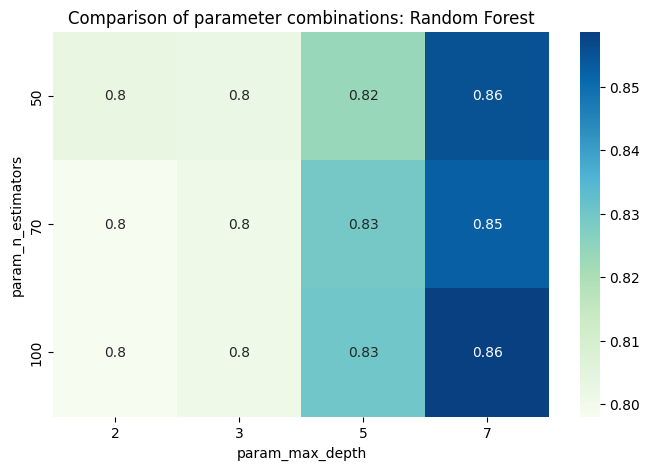

Best Parameters: {'max_depth': 7, 'n_estimators': 100}
Best Score: 0.858680214971488


In [121]:
# Search for best parameter combinations
param_grid = {
    'n_estimators': [50, 70, 100],
    'max_depth': [2, 3, 5, 7],
}

# Apply GridsearchCV with 5-fold cross validation
cv_split_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
gs = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42, class_weight='balanced'),
    param_grid=param_grid,
    cv=cv_split_strategy,
    scoring='f1',
)
gs.fit(X_train_scaled, y_train)

# Show results comparison
results = pd.DataFrame(gs.cv_results_).sort_values(by=["rank_test_score"])
results = results[
    ["param_n_estimators", "param_max_depth", "mean_test_score", "std_test_score", "rank_test_score"]
]

plt.figure(figsize=(8,5))
results_table = results.pivot_table(index="param_n_estimators", columns="param_max_depth", values="mean_test_score")
ax = sns.heatmap(results_table, annot=True, cmap="GnBu")
ax.set_title("Comparison of parameter combinations: Random Forest")
plt.show()

# Save the model with highest score
print("Best Parameters:", gs.best_params_)
print("Best Score:", gs.best_score_)
rf_model = gs.best_estimator_


## Gradient Boosting

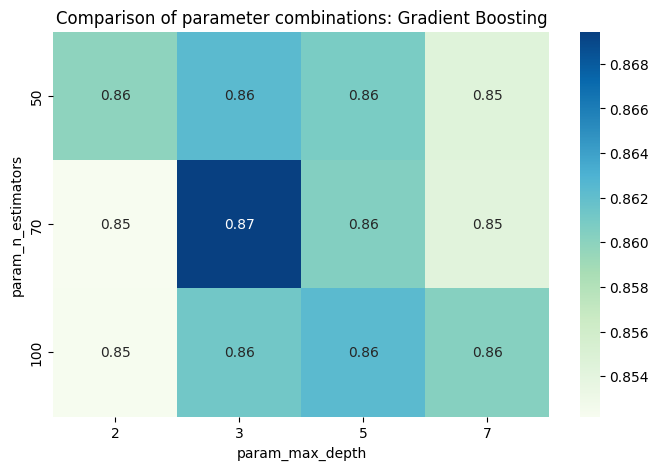

Best Parameters: {'max_depth': 3, 'n_estimators': 70}
Best Score: 0.869435770500127


In [122]:
# Search for best parameter combinations
param_grid = {
    'n_estimators': [50, 70, 100],
    'max_depth': [2, 3, 5, 7],
}

# Apply GridsearchCV with 5-fold cross validation
cv_split_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
gs = GridSearchCV(
    estimator=GradientBoostingClassifier(random_state=42),
    param_grid=param_grid,
    cv=cv_split_strategy,
    scoring='f1',
)
gs.fit(X_train_scaled, y_train)

# Show results comparison
results = pd.DataFrame(gs.cv_results_).sort_values(by=["rank_test_score"])
results = results[
    ["param_n_estimators", "param_max_depth", "mean_test_score", "std_test_score", "rank_test_score"]
]

plt.figure(figsize=(8,5))
results_table = results.pivot_table(index="param_n_estimators", columns="param_max_depth", values="mean_test_score")
ax = sns.heatmap(results_table, annot=True, cmap="GnBu")
ax.set_title("Comparison of parameter combinations: Gradient Boosting")
plt.show()

# Save the model with highest score
print("Best Parameters:", gs.best_params_)
print("Best Score:", gs.best_score_)
gb_model = gs.best_estimator_


# Comparison of four models

In [123]:
# Function for plotting roc-auc curve
def plot_roc_auc_curve(model, X_test_scaled, y_test, model_name):
    if hasattr(model, "decision_function"):
        y_scores = model.decision_function(X_test_scaled)
    elif hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X_test_scaled)[:, 1] # Probability of Class 1
    else:
        raise AttributeError("Model does not support probability or decision function.")

    auc_score = roc_auc_score(y_test, y_scores)
    fpr, tpr, thresholds = roc_curve(y_test, y_scores)

    plt.figure(figsize=(8, 5))
    plt.plot(fpr, tpr, color='darkorange', label=f'{model_name} (AUC = {auc_score:.4f})')
    plt.plot([0, 1], [0, 1], 'k--', color='navy', label='Random Guessing (AUC = 0.5)')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR) / Recall')
    plt.title(f'ROC Curve: {model_name}')
    plt.legend()
    plt.grid(True)
    #plt.savefig(f"ROC_AUC_{model_name}", dpi=300, bbox_inches="tight")
    plt.show()

/tmp/ipython-input-3962013205.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', color='navy', label='Random Guessing (AUC = 0.5)')


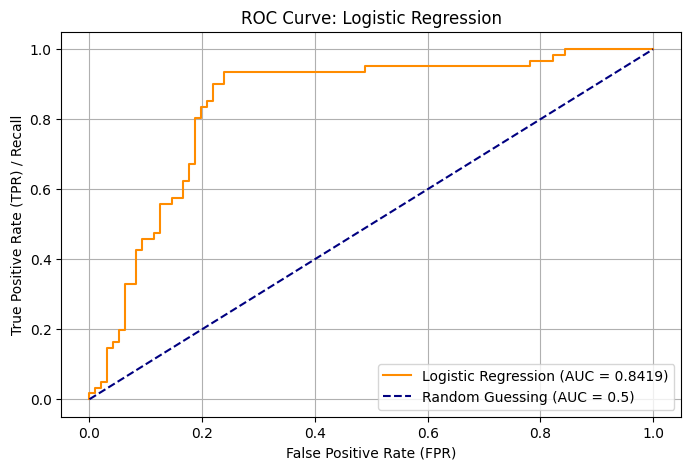

/tmp/ipython-input-3962013205.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', color='navy', label='Random Guessing (AUC = 0.5)')


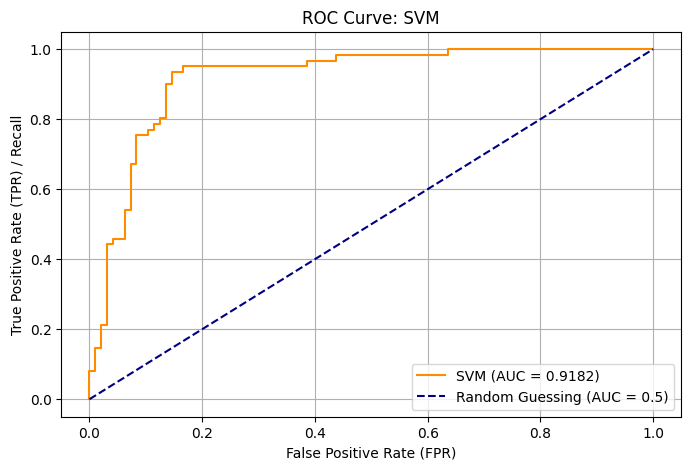

/tmp/ipython-input-3962013205.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', color='navy', label='Random Guessing (AUC = 0.5)')


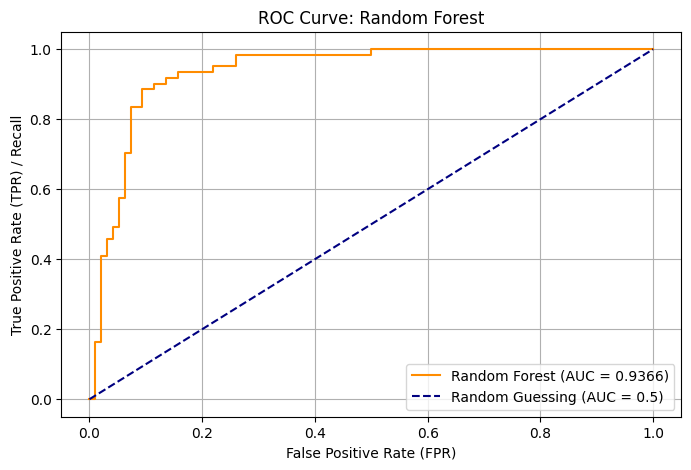

/tmp/ipython-input-3962013205.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', color='navy', label='Random Guessing (AUC = 0.5)')


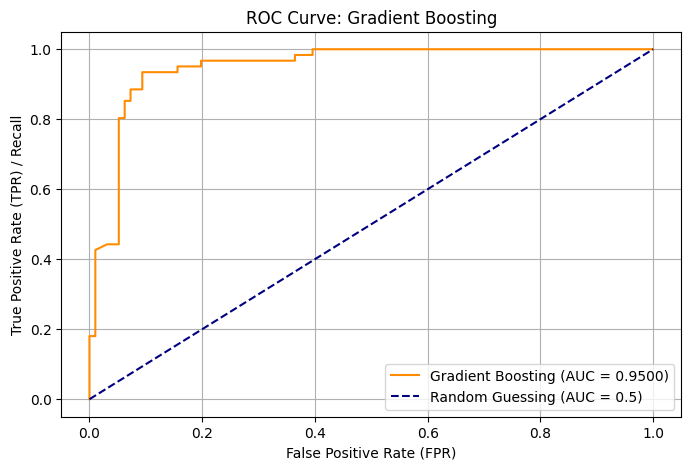

Summary Tables
Train metrics:
            Logistic Regression       SVM  Random Forest  Gradient Boosting
Accuracy              0.819200  0.928000       0.952000           0.968000
Precision             0.704403  0.880769       0.920949           0.970464
Recall                0.921811  0.942387       0.958848           0.946502
F1 score              0.798574  0.910537       0.939516           0.958333
ROC-AUC               0.859921  0.979284       0.994430           0.992831 

Test metrics:
            Logistic Regression       SVM  Random Forest  Gradient Boosting
Accuracy              0.821656  0.872611       0.891720           0.904459
Precision             0.708861  0.805970       0.833333           0.870968
Recall                0.918033  0.885246       0.901639           0.885246
F1 score              0.800000  0.843750       0.866142           0.878049
ROC-AUC               0.841872  0.918204       0.936646           0.949966 

Confusion matrices


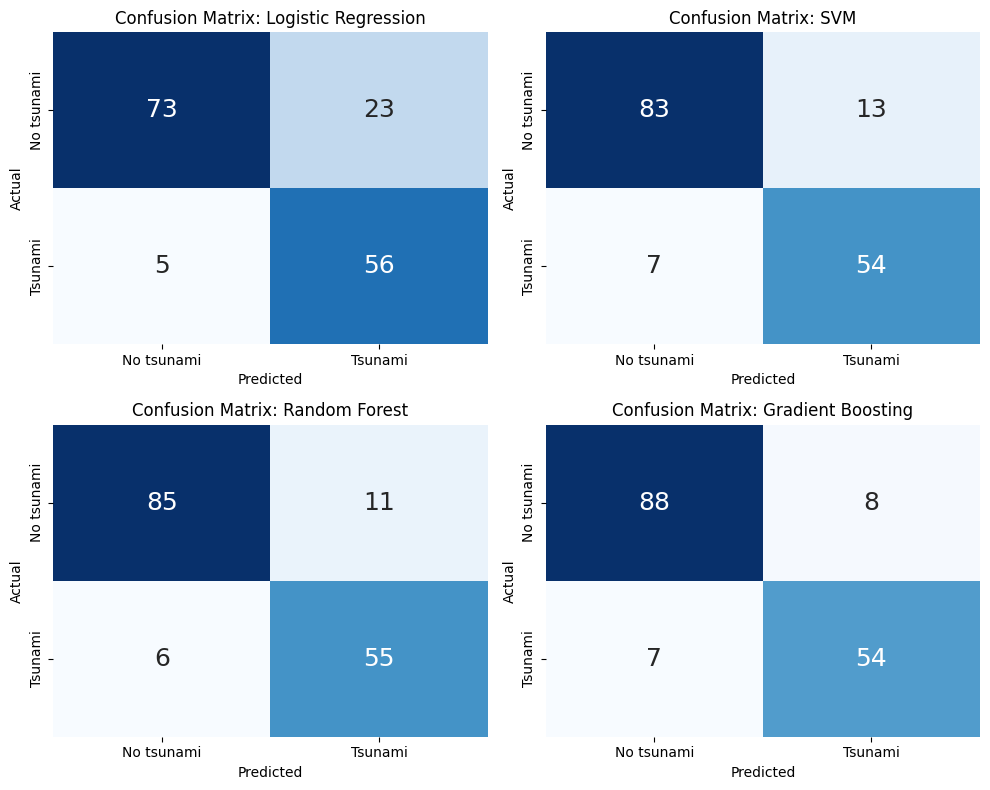

In [124]:
# Define best models
models = {'Logistic Regression': lr_model,
          'SVM': svm_model,
          'Random Forest': rf_model,
          'Gradient Boosting': gb_model}

# Evaluate models
train_metrics = {}
test_metrics = {}

for model_name, model in models.items():
    train_metrics[model_name] = get_eval_metrics(model, X_train_scaled, y_train)
    test_metrics[model_name] = get_eval_metrics(model, X_test_scaled, y_test)

    # Plot ROC-AUC curve
    plot_roc_auc_curve(model, X_test_scaled, y_test, model_name)


# Summary tables
train_metrics_df = pd.DataFrame(train_metrics)
test_metrics_df = pd.DataFrame(test_metrics)
print("="*80)
print('Summary Tables')
print("="*80)
print(f'Train metrics:\n {train_metrics_df} \n')
print(f'Test metrics:\n {test_metrics_df} \n')

# Plot confusion matrices
print("="*80)
print('Confusion matrices')
print("="*80)
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()

for idx, (model_name, model) in enumerate(models.items()):
    y_pred = model.predict(X_test_scaled)
    confusion = confusion_matrix(y_test, y_pred)
    #print(f"Confusion matrix for {model_name} test set")
    #print(f"TN: {confusion[0, 0]:>4}   FP: {confusion[0, 1]:>4}")
    #print(f"FN: {confusion[1, 0]:>4}   TP: {confusion[1, 1]:>4}")

    ax = axes[idx]
    sns.heatmap(confusion, ax=ax, annot=True, annot_kws={"fontsize": 18}, fmt="d", cmap="Blues", cbar=False)
    ax.set_title(f"Confusion Matrix: {model_name}")
    ax.set_xticklabels(['No tsunami', 'Tsunami'])
    ax.set_yticklabels(['No tsunami', 'Tsunami'])
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

plt.tight_layout()
plt.show()


List number of parameters?

## Feature Importance
nst (Number of seismic monitoring stations) has the strongest negative correlation, while dmin (distance to nearest seismic station), cdi (Community Decimal Intensity (felt intensity)) has relatively strong positive correlations.

In [125]:
# Feature importance
importance = lr_model.coef_
features = X.columns
for i in range(len(features)):
    print(f"{features[i]}: {importance[0][i]:.6f}")

magnitude: 0.053515
cdi: 0.198336
mmi: -0.103031
sig: -0.061584
nst: -0.676527
dmin: 0.304337
gap: 0.090019
depth: -0.012688
latitude: -0.060494
longitude: -0.109449
